# Namibian power network in pypsa-earth

This notebook produces network plot for Namibia

In [1]:
import pypsa
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from datetime import datetime
from cartopy import crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from shapely.validation import make_valid

Required files:
- Electricity network found in "networks" directory.
- Shape file for namibia, found in "resources/shape" directory

In [3]:
n_30 = pypsa.Network("../../pypsa-earth-sec/pypsa-earth/networks/elec_s_30.nc")
n_elec = pypsa.Network("../../pypsa-earth-sec/pypsa-earth/networks/elec.nc")

regions_onshore = gpd.read_file("../../pypsa-earth-sec/pypsa-earth/resources/shapes/gadm_shapes_custom.geojson")
regions_offshore = gpd.read_file("../../pypsa-earth-sec/pypsa-earth/resources/shapes/gadm_shapes_offshore_custom.geojson")
substations_OSMclean_path = "../../pypsa-earth-sec/pypsa-earth/resources/osm/clean/all_clean_substations.geojson"

lines_OSMclean_path = "../../pypsa-earth-sec/pypsa-earth/resources/osm/clean/all_clean_lines.geojson"


FileNotFoundError: [Errno 2] No such file or directory: '/home/raj08555/dev/pypsa-earth-sec/pypsa-earth/networks/elec_s_30.nc'

Define plot parameters:

In [ ]:
#bus_scale = 5e3 
#line_scale = 3e3
bus_scale = 9e1 
line_scale = 1e3

In [ ]:

def plot_network(n, line=False, fn=None):
    fig, ax = plt.subplots(figsize=(17, 9), subplot_kw={"projection": ccrs.PlateCarree()})
    gen = n.generators.groupby(["bus", "carrier"]).p_nom.sum()
    sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
    buses = pd.concat([gen, sto])
    lines=0; links=0;
    if line:
        lines = n.lines.s_nom / line_scale
        links=n.links.p_nom / line_scale,

    with plt.rc_context({"patch.linewidth": 0.}):
        n.plot(
            bus_sizes=buses / bus_scale,
            bus_alpha=0.9,
            line_widths=lines,#n.lines.s_nom / line_scale,
            link_widths=links,#n.links.p_nom / line_scale,
            line_colors="teal",
            ax=ax,
            margin=0.2,
            color_geomap=True,
        )
    regions_onshore.plot(
        ax=ax,
        facecolor="white",
        edgecolor="black",
        aspect="equal",
        transform=ccrs.PlateCarree(),
        linewidth=0,
    )
    regions_offshore.plot(
        ax=ax,
        facecolor="blue",
        edgecolor="blue",
        aspect="equal",
        transform=ccrs.PlateCarree(),
        linewidth=1,
    )
    #ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
    ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
    legend_kwargs = {"loc": "upper left", "frameon": False}
    # circles legend may requite some fine-tuning
    legend_circles_dict = {"bbox_to_anchor": (1, 1.1), "labelspacing":11, "handletextpad":7, "title":"Capacity", **legend_kwargs}
    #bus_sizes = [5000, 10e3]  # in MW
    bus_sizes = [10, 100, 500]  # in MW
    line_sizes = [1000, 3000]  # in MW
    add_legend_circles(
        ax,
        [s / bus_scale for s in bus_sizes],
        [f"{s} MW" for s in bus_sizes],
        legend_kw=legend_circles_dict,    
    )
    if line:
        add_legend_lines(
            ax,
            [s / line_scale for s in line_sizes],
            [f"{s / 1000} GW" for s in line_sizes],
            legend_kw={"bbox_to_anchor": (1, 1.0), "handletextpad":7, **legend_kwargs},
        )
    add_legend_patches(
        ax,
        n.carriers.color,
        n.carriers.nice_name,
        legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left", "handletextpad":1.5, "title":"Technology",},
    )
    fig.tight_layout()
#fig.savefig("brownfield_capacities_" + country_code + ".png", bbox_inches="tight", dpi=300)


/home/raj08555/.conda/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


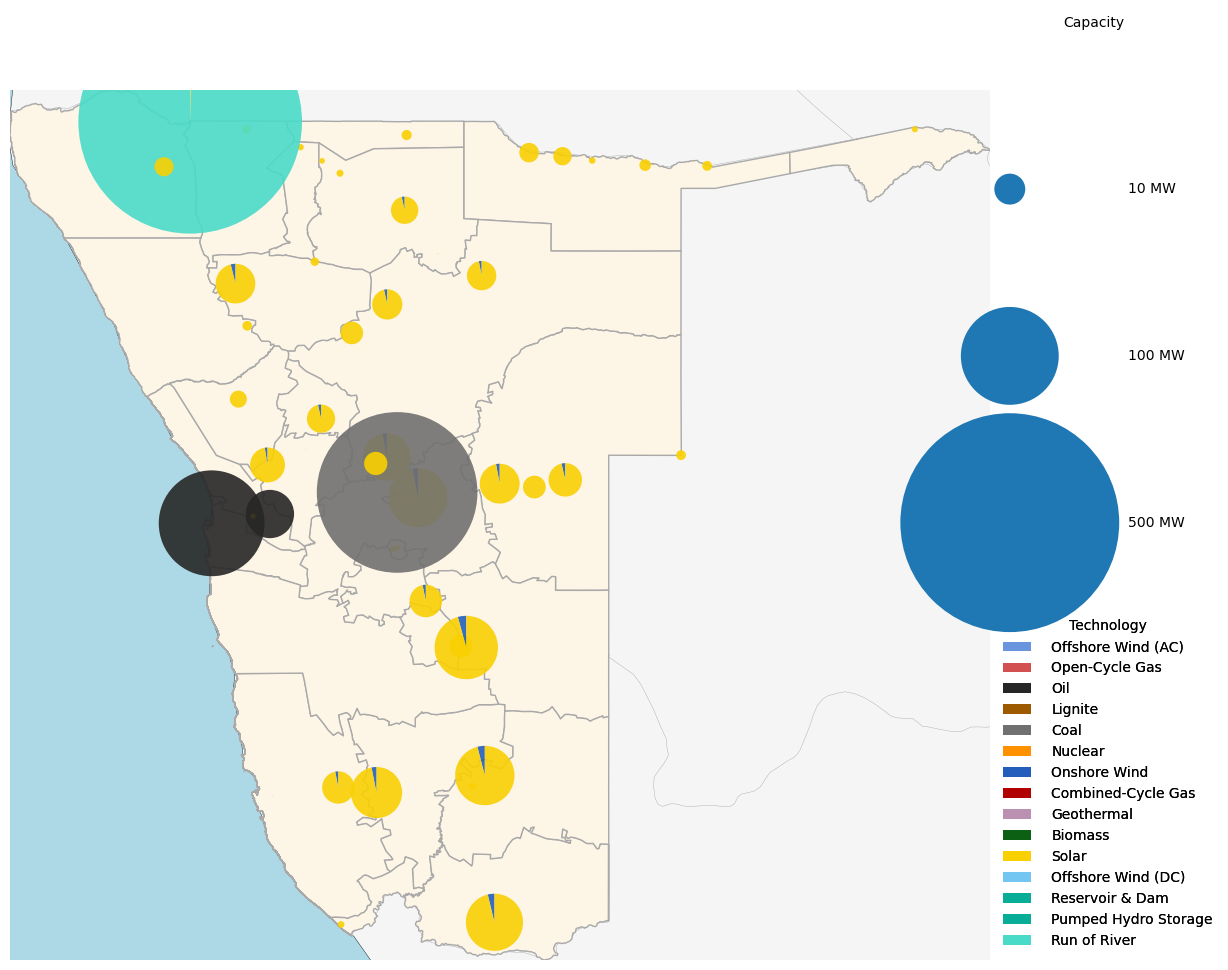

In [ ]:
plot_network(n_elec)

/home/raj08555/.conda/envs/pypsa-earth/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


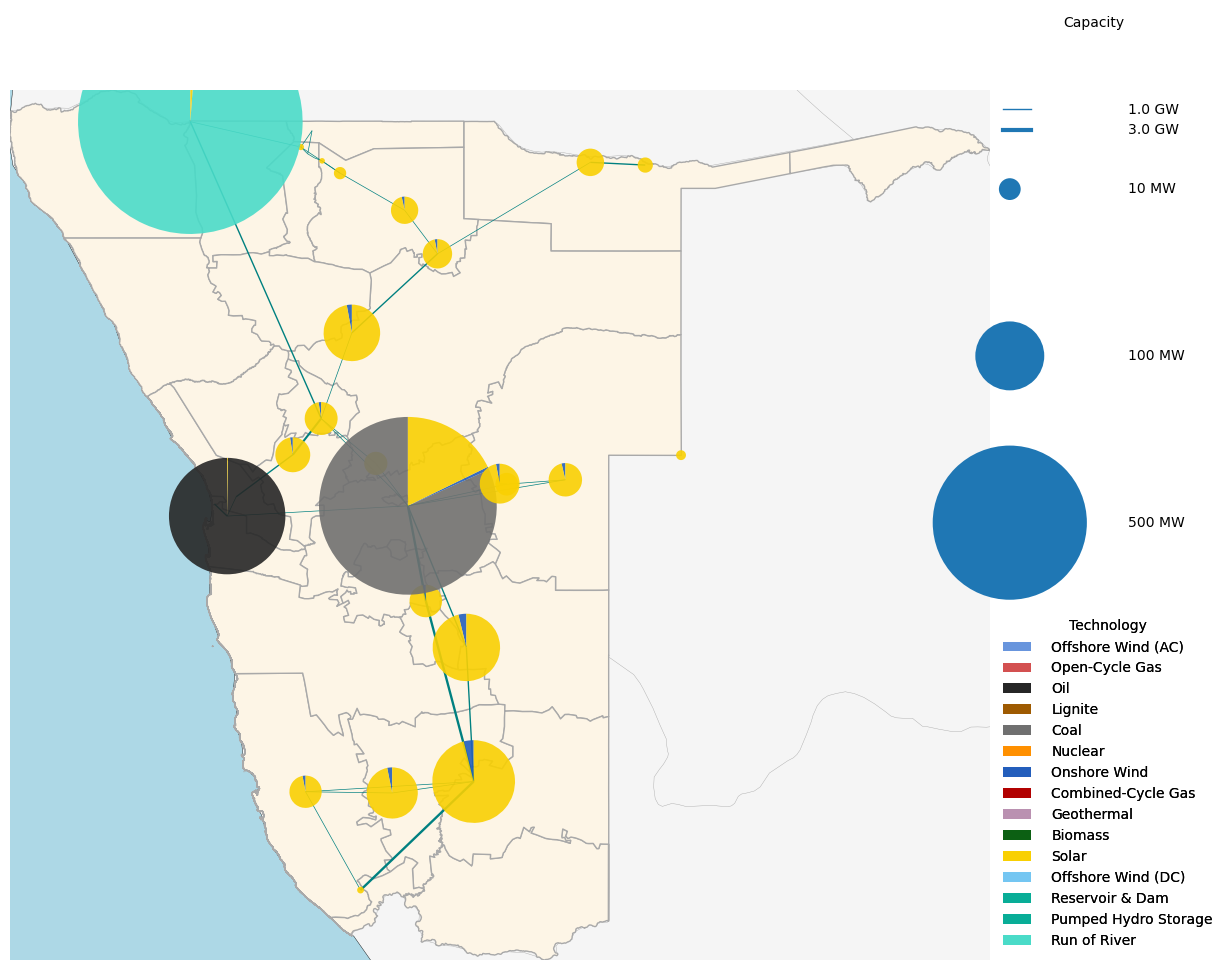

In [ ]:
plot_network(n_30, True)

## 2. Energy production shares

In the following, the total energy production shares as output of the total energy dispatch as available by IEA are compared to those calculated by the pypsa-earth procedure.

The following image depicts the energy demand by source as computed in the Stated Policy Scenarios by [IEA](https://www.iea.org/countries/namibia), which is used as a reference for comparison purposes

- Coal	 :   56 GWh 
- Oil	 :   9 GWh 
- Wind : 18 GWh
- Hydro	 :  1505 GWh 
- Solar PV : 369 GWh 

In [ ]:
# filter only generators in Namibia
def gen_per_carrier(n, fn=None):
    namibia_generators_dispatch = n.generators_t.p.filter(regex="NA *", axis=1).copy()
    # rename column to keep only the carrier 
    namibia_generators_dispatch.rename( 
        columns=dict( 
            zip( 
                namibia_generators_dispatch.columns, 
                map( 
                    lambda x: re.sub(r"NA \d+ ", "", x), namibia_generators_dispatch.columns
                    ), ) ), inplace=True,)
                    
    # obtain generation by carrier
    ( 
        namibia_generators_dispatch.groupby(level=0, axis=1).sum().sum() *  8760/ 
        namibia_generators_dispatch.shape[0]
        / 1000).head(5)
        
    # create empty DataFrame with specific column names & types
    df = pd.DataFrame( 
        { "carrier": pd.Series(dtype="str"), 
        "Generation [GWh]": pd.Series(dtype="float"), 
        "sources": pd.Series(dtype="str") })
        
    carrier_list = n.generators.carrier.unique()
        
    for i in range(0, len(carrier_list)): 
        if carrier_list[i] != "load":
            df.loc[i] = [ carrier_list[i], round( n.generators_t.p.filter(like=carrier_list[i], axis=1).sum().sum()
            / 1000, 2, ), "pypsa 2020"
            ]
        # MWh to GWh 
        
    iea_gen = pd.DataFrame()

    iea_gen['carrier'] = ["onwind" ,"solar", "oil", "coal", "ror"]
    iea_gen['Generation [GWh]'] = [18, 369, 9, 56, 1505]
    iea_gen['sources'] = "IEA 2020"
    all_gen = pd.concat([df,iea_gen])
    print(all_gen)
    #all_gen.rename(columns={"gen_iea_GWh": "capacity [GW]"}, inplace=True)
    ax = sns.catplot(
     x="carrier",
    y="Generation [GWh]",
    hue="sources",
    data=all_gen,
        palette="Blues_d",
        kind="bar",
        height=10,
        aspect=1.5,)
    ax.set_xticklabels(rotation=90)
        
    sns.move_legend(
            ax, "upper right", bbox_to_anchor=(0.75, 0.94), frameon=True, title=None)
    sns.despine(left=True, bottom=False)
    ax.set(xlabel=None, ylabel="Generation [GWh]", ylim=(0, 3000))
    

  carrier  Generation [GWh]     sources
0  onwind               0.0  pypsa 2020
1   solar               0.0  pypsa 2020
2     oil               0.0  pypsa 2020
3    coal               0.0  pypsa 2020
4     ror               0.0  pypsa 2020
0  onwind              18.0    IEA 2020
1   solar             369.0    IEA 2020
2     oil               9.0    IEA 2020
3    coal              56.0    IEA 2020
4     ror            1505.0    IEA 2020


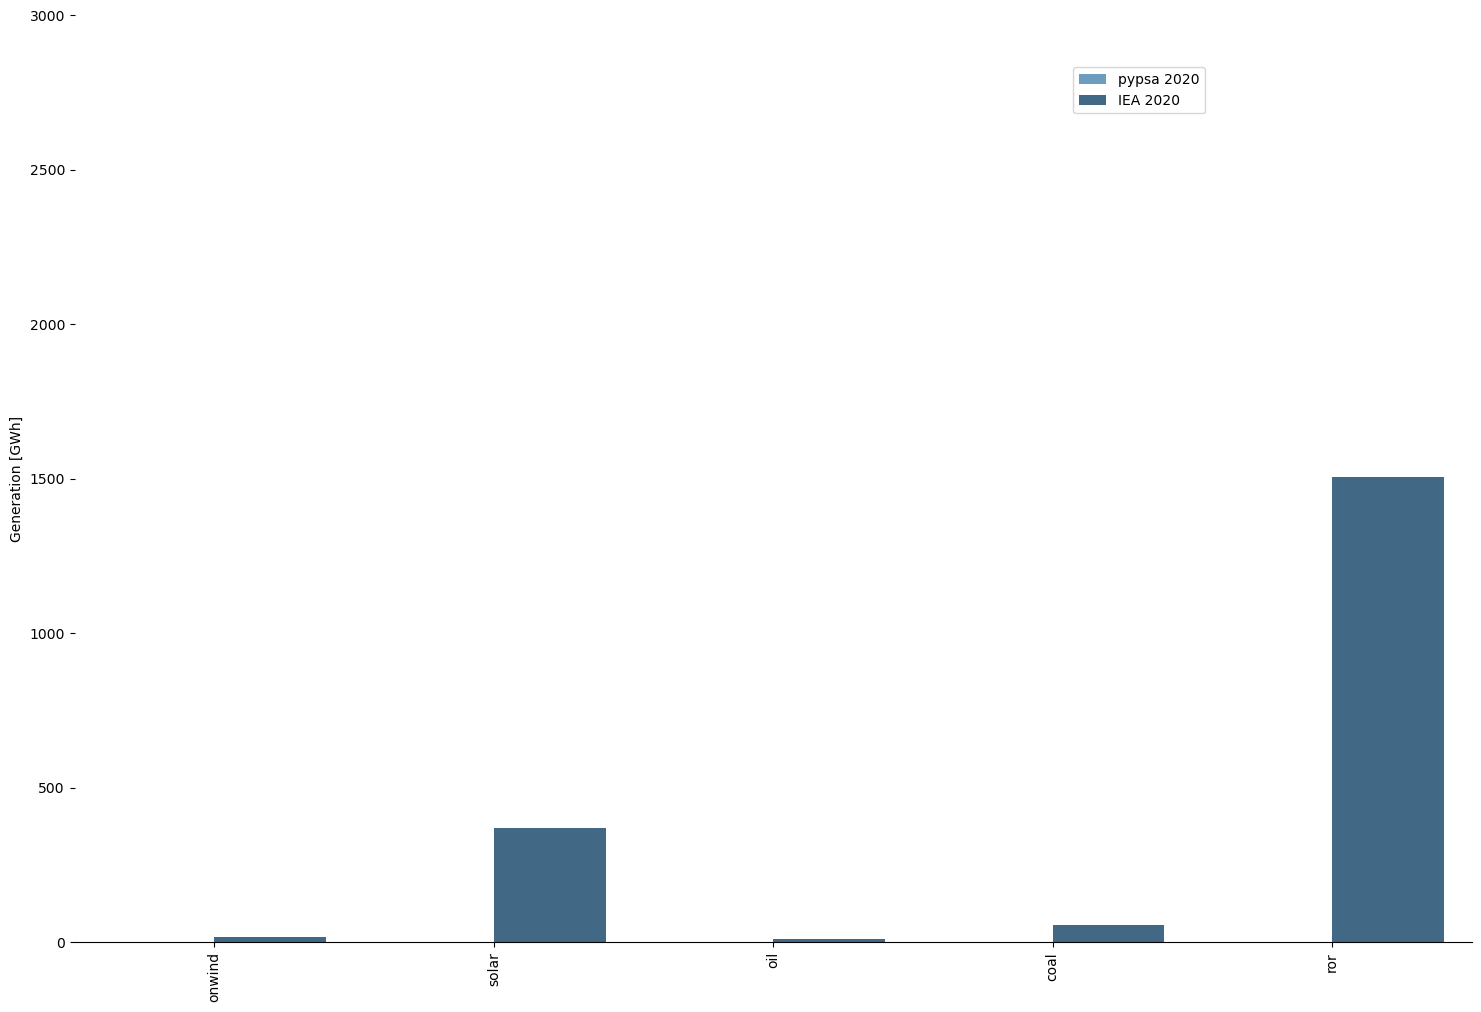

In [ ]:
gen_2030 = gen_per_carrier(n_30)

In [ ]:
# clean substations data
df_substations_clean_osm_africa = gpd.read_file(substations_OSMclean_path)
df_substations_clean_osm_africa["geometry"] = (
    df_substations_clean_osm_africa["geometry"].apply(make_valid).to_crs(epsg=3857)
)
df_substations_clean_osm_namibia = df_substations_clean_osm_africa[
    df_substations_clean_osm_africa.country == "NA"
]

# clean lines data
df_lines_clean_osm_africa = gpd.read_file(lines_OSMclean_path)
df_lines_clean_osm_africa["geometry"] = (
    df_lines_clean_osm_africa["geometry"].apply(make_valid).to_crs(epsg=3857)
)
df_lines_clean_osm_namibia = df_lines_clean_osm_africa[
    df_lines_clean_osm_africa.country == "NA"
]

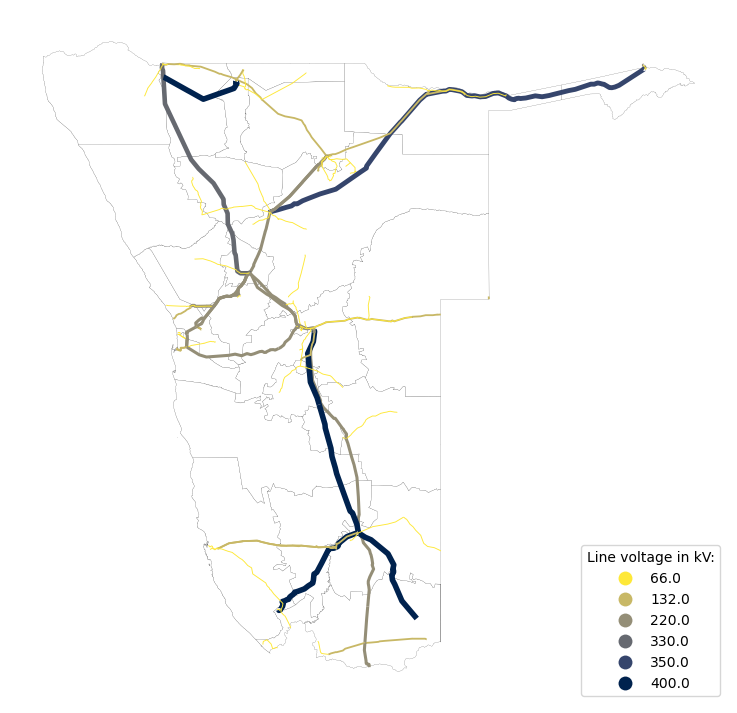

In [ ]:
#plot lines
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(17, 9)
regions_onshore.to_crs(epsg=3857).plot(ax=ax, color="white", edgecolor="black", linewidth=0.1)
df_lines_clean_osm_namibia["voltage_kv"] = df_lines_clean_osm_namibia["voltage"]/1000
df_lines_clean_osm_namibia.to_crs(epsg=3857).plot(
                                                ax=ax,
                                                column='voltage_kv',
                                                linewidth= df_lines_clean_osm_namibia.voltage /100000,
                                                #alpha=0.8,
                                                categorical=True,
                                                cmap='cividis_r',
                                                legend=True,
                                                legend_kwds={'loc':'lower right', 'title':'Line voltage in kV:'}
                                                )
                                                

ax.set_axis_off()                                               
#plt.savefig('./outputs/osm_clean_power_grid.png')

In [ ]:
generators = n_elec.generators
print(generators.columns)
generators = gpd.GeoDataFrame(generators, geometry=gpd.points_from_xy(generators.lon, generators.lat))
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 7)
regions_onshore.plot(ax=ax, color="white", edgecolor="black", linewidth=0.3)
for carrier, data in generators.groupby('carrier'):
    color = fuel_to_color[carrier]

    data.plot(ax=ax,
            #column='carrier',
            markersize=data.p_nom / 10,
            color=color,
            alpha=0.7,
            label = carrier,
            # legend=True
            )
legend = ax.legend(frameon=True, loc=3)
for legend_handle in legend.legendHandles:
    legend_handle._sizes = [10]

generators_visible = generators.loc[generators.p_nom > 10]
_, bins = pd.cut(generators_visible.p_nom/10, bins=3, precision=0, retbins=True)
#bins[0] = generators.p_nom.min() / 10
ax.add_artist(
    ax.legend(
            borderpad=1,
            handles=[
            mlines.Line2D(
                [],
                [],
                color='black',
                lw=0,
                marker='o',
                markersize=np.sqrt(b),
                label=str(round(b*10))+' MW',
            )
            for i, b in enumerate(bins)
        ],
        loc=4,
        labelspacing=2
    )
)

ax.add_artist(legend)
ax.set_axis_off()
plt.savefig('./outputs/generator_map_pre_opt.png')

Index(['carrier', 'bus', 'p_nom_min', 'p_nom', 'p_nom_extendable',
       'efficiency', 'marginal_cost', 'capital_cost', 'build_year', 'lifetime',
       'p_nom_max', 'weight', 'control', 'type', 'p_min_pu', 'p_max_pu',
       'p_set', 'q_set', 'sign', 'committable', 'start_up_cost',
       'shut_down_cost', 'min_up_time', 'min_down_time', 'up_time_before',
       'down_time_before', 'ramp_limit_up', 'ramp_limit_down',
       'ramp_limit_start_up', 'ramp_limit_shut_down', 'p_nom_opt'],
      dtype='object')


AttributeError: 'DataFrame' object has no attribute 'lon'